**Load Module**

In [1]:
# Utils
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import torchvision.models as models
from utility.early_stopping import EarlyStopping
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler


import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

# sklearn
from sklearn.metrics import confusion_matrix, classification_report

**Seed Setting**

In [2]:
random.seed(0)

**Device Setting**

In [3]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Set Hyperparameters**

In [4]:
batch_size = 128
num_epochs = 20
learning_rate = 0.001
momentum = 0.9

# Data Preprocessing

In [5]:
train_val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4), 
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

**Splitting the training data**

In [6]:
train_val_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_val_transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# train 데이터를 train/val로 나누기
num_train = len(train_val_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))  # validation 데이터를 20%로 설정

np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

**Define Dataloader**

In [8]:
train_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=val_sampler, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

**Training Loop**

In [9]:
from models import resnet

print("use:", device)

# 모델 초기화
# net = Net()
net = resnet.resnet18()

# 모델을 GPU로 이동
net.to(device)

print(summary(net, (3,224,224)))

use: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
        BasicBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14       

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]}]


**Model Train**

In [11]:
writer = SummaryWriter("./runs/resnet_18/tensorboard")

In [12]:
early_stopping = EarlyStopping(patience=5, verbose=True)

In [13]:
# 모델 학습 함수
def train_model(model, trainloader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            labels = labels.type(torch.LongTensor).to(device)  # CPU에서 long type tensor로 변환
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # 30번째 배치마다 상태 출력
            if (batch_idx + 1) % 30 == 0:
                print(f"Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        # Epoch당 평균 손실 계산 및 출력
        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Early Stopping 체크
        early_stopping(epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

**Model Test**

In [14]:
# 모델 평가 및 테스트 함수 (superclass 예측 포함)
def test_model(model, testloader, criterion, epoch):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 모델 예측
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)

            # 예측 결과 저장 및 정확도 계산
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()

            # TensorBoard에 테스트 손실 및 정확도 기록
            writer.add_scalar("Test Loss", test_loss / len(testloader.dataset), epoch)
            writer.add_scalar("Test Accuracy", correct / len(testloader.dataset), epoch)

    # 평균 손실 및 정확도 계산
    test_loss /= len(testloader.dataset)
    accuracy = correct / len(testloader.dataset)

    return test_loss, accuracy

**Per-Epoch Training**

In [15]:
for epoch in tqdm(range(1, num_epochs + 1)):
    train_model(net, train_loader, criterion, optimizer, num_epochs=num_epochs)
    test_loss, test_accuracy = test_model(net, test_loader, criterion, epoch)
    writer.add_scalar("Test Loss", test_loss, epoch)
    writer.add_scalar("Test Accuracy", test_accuracy, epoch)
    print(f"Processing Result = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")
    writer.close()

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Batch [30/313], Loss: 4.4863
Batch [60/313], Loss: 4.3542
Batch [90/313], Loss: 4.2681
Batch [120/313], Loss: 4.1839
Batch [150/313], Loss: 4.1910
Batch [180/313], Loss: 4.1077
Batch [210/313], Loss: 3.7774
Batch [240/313], Loss: 3.9519
Batch [270/313], Loss: 3.8174
Batch [300/313], Loss: 3.9042
Epoch [1/20], Loss: 3.2841
Validation loss decreased (inf --> 3.284130).  Saving model ...
Batch [30/313], Loss: 3.8484
Batch [60/313], Loss: 3.8313
Batch [90/313], Loss: 3.7540
Batch [120/313], Loss: 3.5670
Batch [150/313], Loss: 3.5606
Batch [180/313], Loss: 3.7388
Batch [210/313], Loss: 3.5672
Batch [240/313], Loss: 3.4574
Batch [270/313], Loss: 3.4971
Batch [300/313], Loss: 3.3133
Epoch [2/20], Loss: 2.8681
Validation loss decreased (3.284130 --> 2.868148).  Saving model ...
Batch [30/313], Loss: 3.4690
Batch [60/313], Loss: 3.4504
Batch [90/313], Loss: 3.1689
Batch [120/313], Loss: 3.4471
Batch [150/313], Loss: 3.5194
Batch [180/313], Loss: 3.3565
Batch [210/313], Loss: 3.0668
Batch [240/3

  5%|██                                       | 1/20 [03:12<1:00:57, 192.51s/it]

Processing Result = Epoch : 1   Loss : 1.671552334022522   Accuracy : 0.5436
Batch [30/313], Loss: 1.3281
Batch [60/313], Loss: 1.2139
Batch [90/313], Loss: 1.2368
Batch [120/313], Loss: 1.0741
Batch [150/313], Loss: 1.1371
Batch [180/313], Loss: 1.5293
Batch [210/313], Loss: 1.3238
Batch [240/313], Loss: 0.9652
Batch [270/313], Loss: 1.3251
Batch [300/313], Loss: 1.3027
Epoch [1/20], Loss: 1.0088
Validation loss decreased (1.053811 --> 1.008788).  Saving model ...
Batch [30/313], Loss: 1.1283
Batch [60/313], Loss: 1.1368
Batch [90/313], Loss: 1.0674
Batch [120/313], Loss: 1.1415
Batch [150/313], Loss: 1.1258
Batch [180/313], Loss: 1.0599
Batch [210/313], Loss: 1.2072
Batch [240/313], Loss: 1.1885
Batch [270/313], Loss: 1.1524
Batch [300/313], Loss: 1.0471
Epoch [2/20], Loss: 0.9680
Validation loss decreased (1.008788 --> 0.967994).  Saving model ...
Batch [30/313], Loss: 1.2256
Batch [60/313], Loss: 1.1514
Batch [90/313], Loss: 1.0114
Batch [120/313], Loss: 1.2096
Batch [150/313], Los

 10%|████                                     | 2/20 [06:49<1:02:00, 206.72s/it]

Processing Result = Epoch : 2   Loss : 1.5311786291122436   Accuracy : 0.6124
Batch [30/313], Loss: 0.6210
Batch [60/313], Loss: 0.4238
Batch [90/313], Loss: 0.4567
Batch [120/313], Loss: 0.5207
Batch [150/313], Loss: 0.7208
Batch [180/313], Loss: 0.4768
Batch [210/313], Loss: 0.5087
Batch [240/313], Loss: 0.5428
Batch [270/313], Loss: 0.4595
Batch [300/313], Loss: 0.4863
Epoch [1/20], Loss: 0.4112
Validation loss decreased (0.433822 --> 0.411212).  Saving model ...
Batch [30/313], Loss: 0.4103
Batch [60/313], Loss: 0.3985
Batch [90/313], Loss: 0.4712
Batch [120/313], Loss: 0.5504
Batch [150/313], Loss: 0.5881
Batch [180/313], Loss: 0.4736
Batch [210/313], Loss: 0.6061
Batch [240/313], Loss: 0.4379
Batch [270/313], Loss: 0.5698
Batch [300/313], Loss: 0.5042
Epoch [2/20], Loss: 0.3880
Validation loss decreased (0.411212 --> 0.388030).  Saving model ...
Batch [30/313], Loss: 0.3722
Batch [60/313], Loss: 0.4767
Batch [90/313], Loss: 0.4236
Batch [120/313], Loss: 0.4294
Batch [150/313], Lo

 15%|██████▏                                  | 3/20 [10:52<1:03:16, 223.35s/it]

Processing Result = Epoch : 3   Loss : 1.7094793077468873   Accuracy : 0.6236
Batch [30/313], Loss: 0.1333
Batch [60/313], Loss: 0.2545
Batch [90/313], Loss: 0.1439
Batch [120/313], Loss: 0.1751
Batch [150/313], Loss: 0.1711
Batch [180/313], Loss: 0.1421
Batch [210/313], Loss: 0.1513
Batch [240/313], Loss: 0.1297
Batch [270/313], Loss: 0.2012
Batch [300/313], Loss: 0.1482
Epoch [1/20], Loss: 0.1270
Validation loss decreased (0.134607 --> 0.127024).  Saving model ...
Batch [30/313], Loss: 0.1695
Batch [60/313], Loss: 0.1119
Batch [90/313], Loss: 0.0829
Batch [120/313], Loss: 0.1368
Batch [150/313], Loss: 0.1427
Batch [180/313], Loss: 0.1150
Batch [210/313], Loss: 0.1755
Batch [240/313], Loss: 0.1238
Batch [270/313], Loss: 0.1589
Batch [300/313], Loss: 0.1478
Epoch [2/20], Loss: 0.1185
Validation loss decreased (0.127024 --> 0.118499).  Saving model ...
Batch [30/313], Loss: 0.1017
Batch [60/313], Loss: 0.1124
Batch [90/313], Loss: 0.1268
Batch [120/313], Loss: 0.1169
Batch [150/313], Lo

 20%|████████▏                                | 4/20 [15:17<1:03:59, 240.00s/it]

Processing Result = Epoch : 4   Loss : 1.7359450660705567   Accuracy : 0.6454
Batch [30/313], Loss: 0.0445
Batch [60/313], Loss: 0.0627
Batch [90/313], Loss: 0.0472
Batch [120/313], Loss: 0.0360
Batch [150/313], Loss: 0.0616
Batch [180/313], Loss: 0.0575
Batch [210/313], Loss: 0.0418
Batch [240/313], Loss: 0.0555
Batch [270/313], Loss: 0.0678
Batch [300/313], Loss: 0.0444
Epoch [1/20], Loss: 0.0431
Validation loss decreased (0.049389 --> 0.043071).  Saving model ...
Batch [30/313], Loss: 0.0699
Batch [60/313], Loss: 0.0601
Batch [90/313], Loss: 0.0416
Batch [120/313], Loss: 0.0438
Batch [150/313], Loss: 0.0600
Batch [180/313], Loss: 0.0512
Batch [210/313], Loss: 0.0196
Batch [240/313], Loss: 0.0393
Batch [270/313], Loss: 0.0712
Batch [300/313], Loss: 0.0579
Epoch [2/20], Loss: 0.0405
Validation loss decreased (0.043071 --> 0.040496).  Saving model ...
Batch [30/313], Loss: 0.0639
Batch [60/313], Loss: 0.0271
Batch [90/313], Loss: 0.0574
Batch [120/313], Loss: 0.0268
Batch [150/313], Lo

 25%|██████████▎                              | 5/20 [19:50<1:02:55, 251.70s/it]

Processing Result = Epoch : 5   Loss : 1.797564345741272   Accuracy : 0.6521
Batch [30/313], Loss: 0.0161
Batch [60/313], Loss: 0.0226
Batch [90/313], Loss: 0.0261
Batch [120/313], Loss: 0.0205
Batch [150/313], Loss: 0.0235
Batch [180/313], Loss: 0.0366
Batch [210/313], Loss: 0.0226
Batch [240/313], Loss: 0.0366
Batch [270/313], Loss: 0.0227
Batch [300/313], Loss: 0.0227
Epoch [1/20], Loss: 0.0191
Validation loss decreased (0.021395 --> 0.019082).  Saving model ...
Batch [30/313], Loss: 0.0285
Batch [60/313], Loss: 0.0430
Batch [90/313], Loss: 0.0193
Batch [120/313], Loss: 0.0230
Batch [150/313], Loss: 0.0511
Batch [180/313], Loss: 0.0403
Batch [210/313], Loss: 0.0168
Batch [240/313], Loss: 0.0225
Batch [270/313], Loss: 0.0176
Batch [300/313], Loss: 0.0392
Epoch [2/20], Loss: 0.0190
Validation loss decreased (0.019082 --> 0.018955).  Saving model ...
Batch [30/313], Loss: 0.0163
Batch [60/313], Loss: 0.0260
Batch [90/313], Loss: 0.0238
Batch [120/313], Loss: 0.0193
Batch [150/313], Los

 30%|████████████▎                            | 6/20 [24:22<1:00:19, 258.57s/it]

Processing Result = Epoch : 6   Loss : 1.8667784387588502   Accuracy : 0.654
Batch [30/313], Loss: 0.0118
Batch [60/313], Loss: 0.0172
Batch [90/313], Loss: 0.0145
Batch [120/313], Loss: 0.0089
Batch [150/313], Loss: 0.0275
Batch [180/313], Loss: 0.0141
Batch [210/313], Loss: 0.0104
Batch [240/313], Loss: 0.0092
Batch [270/313], Loss: 0.0288
Batch [300/313], Loss: 0.0139
Epoch [1/20], Loss: 0.0143
EarlyStopping counter: 3 out of 5
Batch [30/313], Loss: 0.0298
Batch [60/313], Loss: 0.0278
Batch [90/313], Loss: 0.0083
Batch [120/313], Loss: 0.0133
Batch [150/313], Loss: 0.0101
Batch [180/313], Loss: 0.0114
Batch [210/313], Loss: 0.0123
Batch [240/313], Loss: 0.0130
Batch [270/313], Loss: 0.0176
Batch [300/313], Loss: 0.0236
Epoch [2/20], Loss: 0.0121
Validation loss decreased (0.012867 --> 0.012144).  Saving model ...
Batch [30/313], Loss: 0.0151
Batch [60/313], Loss: 0.0113
Batch [90/313], Loss: 0.0265
Batch [120/313], Loss: 0.0122
Batch [150/313], Loss: 0.0106
Batch [180/313], Loss: 0.

 35%|███████████████                            | 7/20 [28:52<56:51, 262.43s/it]

Processing Result = Epoch : 7   Loss : 1.8418288753509522   Accuracy : 0.6598
Batch [30/313], Loss: 0.0089
Batch [60/313], Loss: 0.0063
Batch [90/313], Loss: 0.0070
Batch [120/313], Loss: 0.0145
Batch [150/313], Loss: 0.0063
Batch [180/313], Loss: 0.0184
Batch [210/313], Loss: 0.0120
Batch [240/313], Loss: 0.0089
Batch [270/313], Loss: 0.0061
Batch [300/313], Loss: 0.0081
Epoch [1/20], Loss: 0.0091
EarlyStopping counter: 3 out of 5
Batch [30/313], Loss: 0.0121
Batch [60/313], Loss: 0.0100
Batch [90/313], Loss: 0.0058
Batch [120/313], Loss: 0.0175
Batch [150/313], Loss: 0.0155
Batch [180/313], Loss: 0.0055
Batch [210/313], Loss: 0.0114
Batch [240/313], Loss: 0.0253
Batch [270/313], Loss: 0.0142
Batch [300/313], Loss: 0.0064
Epoch [2/20], Loss: 0.0084
EarlyStopping counter: 4 out of 5
Batch [30/313], Loss: 0.0089
Batch [60/313], Loss: 0.0046
Batch [90/313], Loss: 0.0074
Batch [120/313], Loss: 0.0111
Batch [150/313], Loss: 0.0078
Batch [180/313], Loss: 0.0175
Batch [210/313], Loss: 0.0039

 40%|█████████████████▏                         | 8/20 [32:41<50:21, 251.82s/it]

Processing Result = Epoch : 8   Loss : 1.8662958948135375   Accuracy : 0.6599
Batch [30/313], Loss: 0.0058
Batch [60/313], Loss: 0.0151
Batch [90/313], Loss: 0.0054
Batch [120/313], Loss: 0.0045
Batch [150/313], Loss: 0.0077
Batch [180/313], Loss: 0.0070
Batch [210/313], Loss: 0.0055
Batch [240/313], Loss: 0.0145
Batch [270/313], Loss: 0.0115
Batch [300/313], Loss: 0.0401
Epoch [1/20], Loss: 0.0059
EarlyStopping counter: 6 out of 5
Early stopping


 45%|███████████████████▎                       | 9/20 [32:56<32:33, 177.62s/it]

Processing Result = Epoch : 9   Loss : 1.865315894317627   Accuracy : 0.6625
Batch [30/313], Loss: 0.0085
Batch [60/313], Loss: 0.0051
Batch [90/313], Loss: 0.0128
Batch [120/313], Loss: 0.0051
Batch [150/313], Loss: 0.0047
Batch [180/313], Loss: 0.0029
Batch [210/313], Loss: 0.0072
Batch [240/313], Loss: 0.0040
Batch [270/313], Loss: 0.0064
Batch [300/313], Loss: 0.0389
Epoch [1/20], Loss: 0.0050
Validation loss decreased (0.005103 --> 0.005028).  Saving model ...
Early stopping


 50%|█████████████████████                     | 10/20 [33:10<21:13, 127.34s/it]

Processing Result = Epoch : 10   Loss : 1.8631847387313842   Accuracy : 0.6648
Batch [30/313], Loss: 0.0029
Batch [60/313], Loss: 0.0093
Batch [90/313], Loss: 0.0063
Batch [120/313], Loss: 0.0055
Batch [150/313], Loss: 0.0029
Batch [180/313], Loss: 0.0043
Batch [210/313], Loss: 0.0041
Batch [240/313], Loss: 0.0049
Batch [270/313], Loss: 0.0034
Batch [300/313], Loss: 0.0038
Epoch [1/20], Loss: 0.0047
Validation loss decreased (0.005028 --> 0.004724).  Saving model ...
Early stopping


 55%|███████████████████████▋                   | 11/20 [33:25<13:55, 92.78s/it]

Processing Result = Epoch : 11   Loss : 1.8563789834976197   Accuracy : 0.6645
Batch [30/313], Loss: 0.0050
Batch [60/313], Loss: 0.0060
Batch [90/313], Loss: 0.0029
Batch [120/313], Loss: 0.0036
Batch [150/313], Loss: 0.0057
Batch [180/313], Loss: 0.0032
Batch [210/313], Loss: 0.0075
Batch [240/313], Loss: 0.0051
Batch [270/313], Loss: 0.0318
Batch [300/313], Loss: 0.0079
Epoch [1/20], Loss: 0.0047
Validation loss decreased (0.004724 --> 0.004696).  Saving model ...
Early stopping


 60%|█████████████████████████▊                 | 12/20 [33:39<09:11, 68.98s/it]

Processing Result = Epoch : 12   Loss : 1.8693509323120117   Accuracy : 0.6637
Batch [30/313], Loss: 0.0086
Batch [60/313], Loss: 0.0083
Batch [90/313], Loss: 0.0064
Batch [120/313], Loss: 0.0065
Batch [150/313], Loss: 0.0085
Batch [180/313], Loss: 0.0054
Batch [210/313], Loss: 0.0053
Batch [240/313], Loss: 0.0079
Batch [270/313], Loss: 0.0039
Batch [300/313], Loss: 0.0075
Epoch [1/20], Loss: 0.0047
EarlyStopping counter: 1 out of 5
Early stopping


 65%|███████████████████████████▉               | 13/20 [33:54<06:07, 52.55s/it]

Processing Result = Epoch : 13   Loss : 1.8668282299041747   Accuracy : 0.6618
Batch [30/313], Loss: 0.0062
Batch [60/313], Loss: 0.0039
Batch [90/313], Loss: 0.0082
Batch [120/313], Loss: 0.0071
Batch [150/313], Loss: 0.0042
Batch [180/313], Loss: 0.0028
Batch [210/313], Loss: 0.0032
Batch [240/313], Loss: 0.0031
Batch [270/313], Loss: 0.0037
Batch [300/313], Loss: 0.0103
Epoch [1/20], Loss: 0.0044
Validation loss decreased (0.004696 --> 0.004356).  Saving model ...
Early stopping


 70%|██████████████████████████████             | 14/20 [34:08<04:05, 40.97s/it]

Processing Result = Epoch : 14   Loss : 1.8666073148727418   Accuracy : 0.665
Batch [30/313], Loss: 0.0026
Batch [60/313], Loss: 0.0030
Batch [90/313], Loss: 0.0196
Batch [120/313], Loss: 0.0124
Batch [150/313], Loss: 0.0029
Batch [180/313], Loss: 0.0408
Batch [210/313], Loss: 0.0034
Batch [240/313], Loss: 0.0077
Batch [270/313], Loss: 0.0088
Batch [300/313], Loss: 0.0149
Epoch [1/20], Loss: 0.0057
EarlyStopping counter: 1 out of 5
Early stopping


 75%|████████████████████████████████▎          | 15/20 [34:23<02:45, 33.01s/it]

Processing Result = Epoch : 15   Loss : 1.8768393379211425   Accuracy : 0.6604
Batch [30/313], Loss: 0.0045
Batch [60/313], Loss: 0.0030
Batch [90/313], Loss: 0.0357
Batch [120/313], Loss: 0.0023
Batch [150/313], Loss: 0.0063
Batch [180/313], Loss: 0.0048
Batch [210/313], Loss: 0.0096
Batch [240/313], Loss: 0.0033
Batch [270/313], Loss: 0.0109
Batch [300/313], Loss: 0.0021
Epoch [1/20], Loss: 0.0049
EarlyStopping counter: 2 out of 5
Early stopping


 80%|██████████████████████████████████▍        | 16/20 [34:37<01:49, 27.44s/it]

Processing Result = Epoch : 16   Loss : 1.8683209217071532   Accuracy : 0.665
Batch [30/313], Loss: 0.0057
Batch [60/313], Loss: 0.0051
Batch [90/313], Loss: 0.0055
Batch [120/313], Loss: 0.0069
Batch [150/313], Loss: 0.0046
Batch [180/313], Loss: 0.0068
Batch [210/313], Loss: 0.0100
Batch [240/313], Loss: 0.0041
Batch [270/313], Loss: 0.0042
Batch [300/313], Loss: 0.0087
Epoch [1/20], Loss: 0.0056
EarlyStopping counter: 3 out of 5
Early stopping


 85%|████████████████████████████████████▌      | 17/20 [34:52<01:10, 23.60s/it]

Processing Result = Epoch : 17   Loss : 1.8644814086914063   Accuracy : 0.6619
Batch [30/313], Loss: 0.0055
Batch [60/313], Loss: 0.0057
Batch [90/313], Loss: 0.0042
Batch [120/313], Loss: 0.0027
Batch [150/313], Loss: 0.0039
Batch [180/313], Loss: 0.0042
Batch [210/313], Loss: 0.0038
Batch [240/313], Loss: 0.0040
Batch [270/313], Loss: 0.0059
Batch [300/313], Loss: 0.0035
Epoch [1/20], Loss: 0.0051
EarlyStopping counter: 4 out of 5
Early stopping


 90%|██████████████████████████████████████▋    | 18/20 [35:07<00:41, 20.86s/it]

Processing Result = Epoch : 18   Loss : 1.8687571321487426   Accuracy : 0.6612
Batch [30/313], Loss: 0.0108
Batch [60/313], Loss: 0.0092
Batch [90/313], Loss: 0.0033
Batch [120/313], Loss: 0.0096
Batch [150/313], Loss: 0.0039
Batch [180/313], Loss: 0.0093
Batch [210/313], Loss: 0.0044
Batch [240/313], Loss: 0.0057
Batch [270/313], Loss: 0.0137
Batch [300/313], Loss: 0.0080
Epoch [1/20], Loss: 0.0057
EarlyStopping counter: 5 out of 5
Early stopping


 95%|████████████████████████████████████████▊  | 19/20 [35:21<00:19, 19.03s/it]

Processing Result = Epoch : 19   Loss : 1.8856626342773437   Accuracy : 0.6625
Batch [30/313], Loss: 0.0076
Batch [60/313], Loss: 0.0071
Batch [90/313], Loss: 0.0074
Batch [120/313], Loss: 0.0416
Batch [150/313], Loss: 0.0035
Batch [180/313], Loss: 0.0056
Batch [210/313], Loss: 0.0053
Batch [240/313], Loss: 0.0151
Batch [270/313], Loss: 0.0040
Batch [300/313], Loss: 0.0077
Epoch [1/20], Loss: 0.0048
EarlyStopping counter: 6 out of 5
Early stopping


100%|██████████████████████████████████████████| 20/20 [35:36<00:00, 106.83s/it]

Processing Result = Epoch : 20   Loss : 1.8754571912765503   Accuracy : 0.6657


In [16]:
# for data, target in val_loader:
#     data, target = data.to(device), target.to(device)
#     output = model(data)
#     print("Sample output:", output)  # 모델의 출력 예시를 출력
#     break  # 첫 번째 배치만 확인

**Result**

In [17]:
print(f" Result of ResNet = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")

 Result of ResNet = Epoch : 20   Loss : 1.8754571912765503   Accuracy : 0.6657


**Test**

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개 테스트 이미지에서 모델 정확도: %.2f %%' % (
    100 * correct / total))

10000개 테스트 이미지에서 모델 정확도: 66.57 %


**Visualization of average loss**

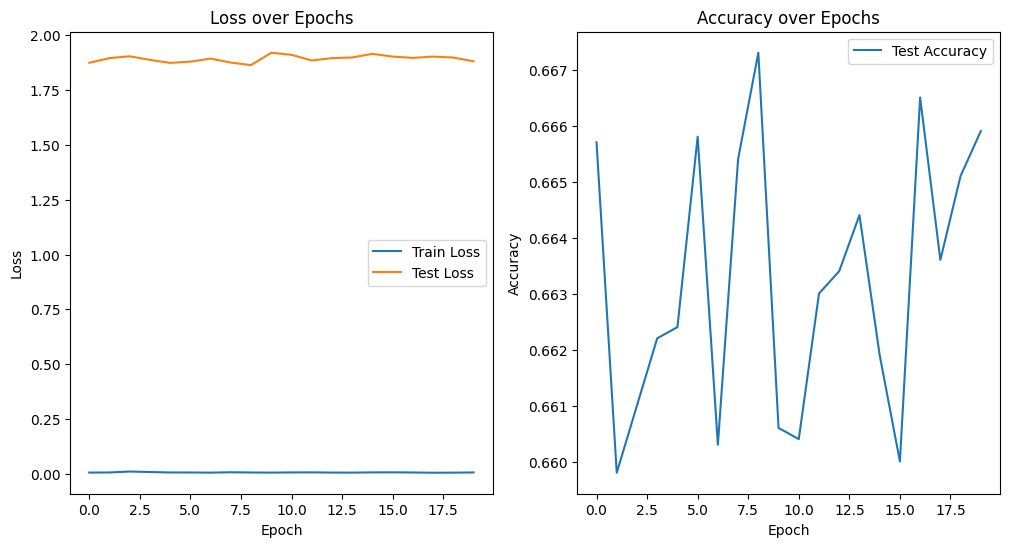

In [19]:
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # 훈련과정에서 손실을 기록
    train_loss = 0
    total_samples = 0
    net.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
    
    train_losses.append(train_loss / total_samples)

    # 평가 과정에서 손실과 정확도를 기록
    test_loss = 0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(test_loss / total)
    test_accuracies.append(correct / total)

# 손실과 정확도 그래프 그리기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Top-1 Accuracy**

In [20]:
def calculate_top1_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # # 각 샘플에 대한 예측 결과와 실제 레이블 출력
            # for i in range(data.size(0)):
            #     print(f"Sample {i + 1}: Predicted = {predicted[i].item()}, Actual = {target[i].item()}")

    top1_accuracy = 100 * correct / total
    print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")

In [24]:
# 모델 훈련 후 검증 데이터셋에 대한 Top-1 정확도 계산 및 출력
calculate_top1_accuracy(net, device, val_loader, criterion)

Top-1 Accuracy: 65.20%


**Top-5 Accuracy**

In [22]:
def calculate_and_print_top5_accuracy(model, device, data_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            # Top-5 예측 결과 가져오기
            _, predicted_top5 = torch.topk(outputs, 5, dim=1)
            total += target.size(0)
            
            # 예측된 Top-5 내에 실제 레이블이 있는지 확인
            correct += (predicted_top5 == target.view(-1, 1)).sum().item()

    top5_accuracy = 100 * correct / total
    print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

In [23]:
calculate_and_print_top5_accuracy(net, device, val_loader, criterion)

Top-5 Accuracy: 88.06%


**Super Class Accuracy**